In [40]:
#Installing the imbalanced learn module for access to a variety of over-sampling methods

#!pip install imbalanced-learn
#!pip install numpy==1.21

In [41]:
import pandas as pd
import seaborn as sns

In [42]:
df = pd.read_csv('Data\clean_gss.csv')
df.head()

,Unnamed: 0,LONELY2,SATJOB,MOREDAYS,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,AGE,MARITAL,EDUC,is_si,MOREWEEKS,Age Group
0,3,2.0,1.0,2.0,1.0,1.0,1.0,4.0,3.0,63.0,1.0,4,0,1,4
1,6,3.0,1.0,1.0,1.0,3.0,2.0,3.0,2.0,59.0,3.0,3,1,1,3
2,7,1.0,1.0,24.0,1.0,2.0,3.0,4.0,5.0,43.0,5.0,2,0,4,2
3,9,3.0,2.0,3.0,1.0,2.0,3.0,4.0,1.0,55.0,1.0,2,1,1,3
4,11,3.0,2.0,6.0,1.0,3.0,3.0,2.0,1.0,34.0,4.0,3,1,1,2


In [43]:
# Getting rid of redundant columns from initial dataframe

gss= df[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','MARITAL', 'EDUC', 'is_si', 'MOREWEEKS', 'Age Group']]
gss.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,MARITAL,EDUC,is_si,MOREWEEKS,Age Group
0,1.0,1.0,1.0,1.0,4.0,3.0,1.0,4,0,1,4
1,1.0,1.0,3.0,2.0,3.0,2.0,3.0,3,1,1,3
2,1.0,1.0,2.0,3.0,4.0,5.0,5.0,2,0,4,2
3,2.0,1.0,2.0,3.0,4.0,1.0,1.0,2,1,1,3
4,2.0,1.0,3.0,3.0,2.0,1.0,4.0,3,1,1,2


<AxesSubplot:>

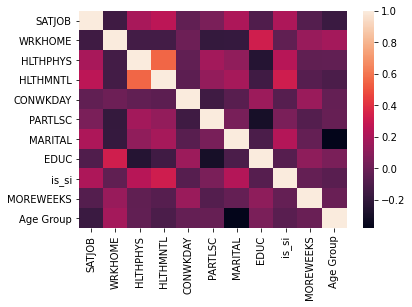

In [44]:
# Checking for multicollinearity- looks good

corr = gss.corr()
sns.heatmap(corr)

In [45]:
# Marital status is the only nominal categorical variable in this dataframe. Using get_dummies to one-hot encode and
# dropping first level of marital status: a zero for marital_2, marital_3, marital_4, and marital_5 implies row belongs
# to marital_1. The rest of the variables are ordinal and attempting to run logit with variables as-is.

gss= pd.get_dummies(gss, columns= ['MARITAL'], prefix= 'Marital', drop_first= True)
gss.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,EDUC,is_si,MOREWEEKS,Age Group,Marital_2.0,Marital_3.0,Marital_4.0,Marital_5.0
0,1.0,1.0,1.0,1.0,4.0,3.0,4,0,1,4,0,0,0,0
1,1.0,1.0,3.0,2.0,3.0,2.0,3,1,1,3,0,1,0,0
2,1.0,1.0,2.0,3.0,4.0,5.0,2,0,4,2,0,0,0,1
3,2.0,1.0,2.0,3.0,4.0,1.0,2,1,1,3,0,0,0,0
4,2.0,1.0,3.0,3.0,2.0,1.0,3,1,1,2,0,0,1,0


In [46]:
# Starting to split data to prepare for modeling

X= gss[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','EDUC', 'MOREWEEKS', 'Age Group', 'Marital_2.0','Marital_3.0', 'Marital_4.0', 'Marital_5.0' ]]
y= gss['is_si']

In [47]:
from imblearn.over_sampling import SMOTEN
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

# Resampling only the training data
os= SMOTEN(random_state= 42)
os_X, os_y= os.fit_resample(X_train, y_train)

In [48]:
# Verifying we now have 50/50 isolated to non-isolated for training data

os_y.value_counts()

1    364
0    364
Name: is_si, dtype: int64

In [49]:
# SATJOB, HLTHPHYS, PARTLSC, MARITAL_2, MARITAL_5 all have p-value above 0.05 lacking statistical significance

import statsmodels.api as sm

sm_logit = sm.Logit(os_y, os_X)
result = sm_logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.553857
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  728
Model:                          Logit   Df Residuals:                      715
Method:                           MLE   Df Model:                           12
Date:                Tue, 04 Apr 2023   Pseudo R-squ.:                  0.2010
Time:                        12:11:34   Log-Likelihood:                -403.21
converged:                       True   LL-Null:                       -504.61
Covariance Type:            nonrobust   LLR p-value:                 8.591e-37
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
SATJOB          0.2314      0.116      1.988      0.047       0.003       0.460
WRKHOME        -0.2439    

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

sk_logit = LogisticRegression()
sk_logit.fit(os_X, os_y)
y_pred = sk_logit.predict(X_test)
print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))

Accuracy on test set:0.68


In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77       156
           1       0.41      0.63      0.49        51

    accuracy                           0.68       207
   macro avg       0.63      0.66      0.63       207
weighted avg       0.74      0.68      0.70       207



In [52]:
for age_group in gss['Age Group'].unique():
    age = gss.loc[gss['Age Group']== age_group]
    
    # Starting to split data to prepare for modeling
    
    #'Marital_2.0','Marital_3.0', 'Marital_4.0', 'Marital_5.0'
    X= age[['SATJOB','WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC','EDUC', 'MOREWEEKS']]
    y= age['is_si']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

    # Resampling only the training data
    os= SMOTEN(random_state= 42)
    os_X, os_y= os.fit_resample(X_train, y_train)

    sm_logit = sm.Logit(os_y, os_X)
    result = sm_logit.fit()
    print("Age Group:{:.2f}".format(age_group))
    print(result.summary())

    sk_logit = LogisticRegression()
    sk_logit.fit(os_X, os_y)
    y_pred = sk_logit.predict(X_test)
    print('Accuracy on test set:{:.2f}'.format(sk_logit.score(X_test, y_test)))
    

Optimization terminated successfully.
         Current function value: 0.457409
         Iterations 6
Age Group:4.00
                           Logit Regression Results                           
Dep. Variable:                  is_si   No. Observations:                  104
Model:                          Logit   Df Residuals:                       96
Method:                           MLE   Df Model:                            7
Date:                Tue, 04 Apr 2023   Pseudo R-squ.:                  0.3401
Time:                        12:11:34   Log-Likelihood:                -47.571
converged:                       True   LL-Null:                       -72.087
Covariance Type:            nonrobust   LLR p-value:                 2.235e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SATJOB        -0.7144      0.456     -1.565      0.118      -1.609       0.180
WRKHOME       